In [1]:
!pip install torchsummary

In [56]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import pickle
import time
import os
import os.path
import sys
import pandas as pd
from torchsummary import summary
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [58]:
EPOCHS = 300
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_CLASSES = 5
TRAIN_DATA_PATH="../input/mayank-cheetah/output/" #replace with directory containing output folder ccontaining datatset
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#     to normalize between(0.5,0.5)
#     transforms.Normalize(mean=[.5, .5, .5],std=[1 ,1, 1]) 
    ])

In [59]:
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data.__len__()

22553

In [60]:
train_set, val_set = torch.utils.data.random_split(train_data, [int(np.floor(0.9*train_data.__len__())),int(train_data.__len__()-np.floor(0.9*train_data.__len__()))])

In [61]:
train_set = data.DataLoader(train_set, batch_size= BATCH_SIZE, shuffle=True, num_workers=4)
val_set = data.DataLoader(val_set, batch_size= BATCH_SIZE, num_workers=4)
val_set.__len__()

36

In [62]:
 #replace with directory containing output folder ccontaining datatset
classes = [d for d in os.listdir('../input/mayank-cheetah/output/') if os.path.isdir(os.path.join('../input/mayank-cheetah/output/', d))]
classes.sort()
class_to_idx = {classes[i]: i for i in range(len(classes))}
class_to_idx 

{'concrete_cement': 0,
 'healthy_metal': 1,
 'incomplete': 2,
 'irregular_metal': 3,
 'other': 4}

In [63]:
# TRIED THIS BASIC MODEL BUT ACCUARY WAS AROUND 66% SO NOT SUITABLE

# class ConvNet(nn.Module):
#     def __init__(self, num_classes=NUM_CLASSES):
#         super(ConvNet, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3, 24, kernel_size=9, stride=1, padding=0),
#             nn.BatchNorm2d(24),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(24, 48, kernel_size=7, stride=1, padding=0),
#             nn.BatchNorm2d(48),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(48, 96, kernel_size=5, stride=1, padding=0),
#             nn.BatchNorm2d(96),
#             nn.MaxPool2d(kernel_size=2, stride=2))
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=0),
#             nn.BatchNorm2d(192),
#             nn.MaxPool2d(kernel_size=2, stride=2))
#         self.fc1 = nn.Sequential(
#             nn.Linear(10*10*192, 512),
#             nn.ReLU())
#         self.fc2 = nn.Sequential(
#             nn.Linear(512,128),
#             nn.ReLU())
#         self.fc3 = nn.Linear(128, num_classes)
#         self.sm = nn.Softmax(dim=-1)
        
#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = out.reshape(out.size(0), -1)
#         out = self.fc1(out)
#         out = self.fc2(out)
#         out = self.fc3(out)
#         out = self.sm(out)
#         return out

In [64]:
#Using Vgg model for tansfer learning
custom_model=torchvision.models.vgg11(pretrained=True)

In [65]:
for param in custom_model.parameters(): #freezing gradients
    param.requires_grad = False   

#adding custom layers in the end for specfic tasks    
custom_model.classifier[-1] = nn.Sequential(
               nn.Linear(4096, 512),
               nn.ReLU(inplace=True),
               nn.Linear(512, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 5))

In [67]:
custom_model = custom_model.to(device)
#to print model summary
summary(custom_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

In [68]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Train the model
losses=[]
total_step = len(train_set)
#start time
# torch.cuda.synchronize()
since = int(round(time.time()*1000))
for epoch in range(EPOCHS):
    running_loss=0.0
    for i, (images, labels) in enumerate(train_set):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = custom_model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        
        if (i+1) % 1 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, EPOCHS, i+1, total_step, loss.item()))
    epoch_loss = running_loss / len(train_set)
    losses.append(epoch_loss)
#stop time
# torch.cuda.synchronize()
time_elapsed = int(round(time.time()*1000)) - since
print ('training time elapsed {}ms'.format(time_elapsed)) #to print whole training time

#saving losses in pickle to plot graph later
pickle_out = open("dict.pickle","wb")
pickle.dump(losses, pickle_out)
pickle_out.close()


In [69]:
#for loading weights from previous saved checkpoints
custom_model.load_state_dict(torch.load('../input/checkpoints-dict/model.ckpt'))

<All keys matched successfully>

In [70]:
# Test the model
custom_model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
predict_list=[]
true_list=[]
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_set:
        images = images.to(device)
        labels = labels.to(device)
        outputs = custom_model(images)
        _, predicted = torch.max(outputs.data, 1)
        predict_list.append(predicted)
        true_list.append(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 2304 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
# torch.save(custom_model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 2304 test images: 96.85283687943263 %


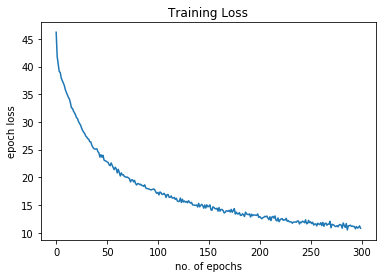

In [72]:
#plotting training graph

with open('../input/checkpoints-dict/dict.pickle', 'rb') as f:
# with open('dict.pickle', 'rb') as f:
    x = pickle.load(f)
plt.title('Training Loss')
plt.xlabel('no. of epochs')
plt.ylabel('epoch loss')
plt.plot(x)

In [84]:
# this is to verify on particular image if classifies well
from PIL import Image
# from torch.autograd import Variable
from IPython.display import display
loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU
def image_show(image_name):
    image = Image.open(image_name).convert("RGB")
    return(image)


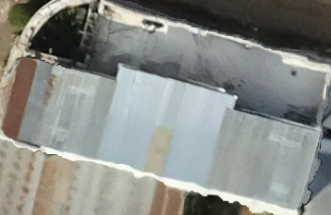

concrete_cement


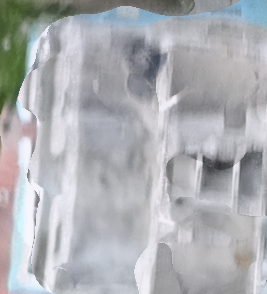

healthy_metal


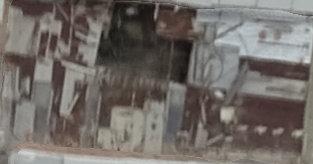

incomplete


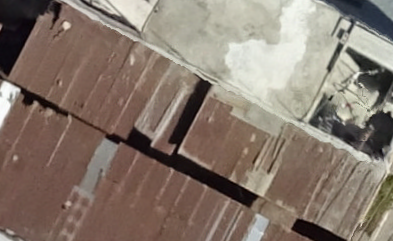

irregular_metal


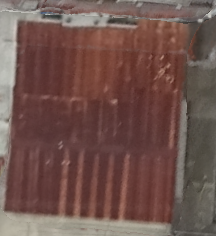

other


In [87]:
base ="../input/mayank-cheetah/output/"
img_list=["concrete_cement/7a27cc58.png","healthy_metal/7a22b3da.png","incomplete/7a2aafae.png","irregular_metal/7a4164c4.png","other/7a3ea4aa.png"]

for i in img_list:
    image = image_loader(base+i)
    display(image_show(base+i))
    
    #verification using one image at a time
    _, predikt= torch.max(custom_model(image).data, 1)
    idx_to_classes={0:'concrete_cement',
      1:'healthy_metal',
      2:'incomplete',
      3:'irregular_metal',
      4: 'other',
      }
    print(idx_to_classes[predikt.item()])

In [80]:
a = predict_list[0].cpu().numpy()
for i in range(1,val_set.__len__()):
    a = np.hstack((a, predict_list[i].cpu().numpy()))
b = true_list[0].cpu().numpy()
for i in range(1,val_set.__len__()):
    b = np.hstack((b, true_list[i].cpu().numpy()))

y_actu = pd.Series(b, name='Actual')
y_pred = pd.Series(a, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, margins=True)
df_confusion_new = df_confusion.rename(columns=idx_to_classes, index=idx_to_classes)

In [81]:
df_confusion_new 

Predicted,concrete_cement,healthy_metal,incomplete,irregular_metal,other,All
Actual,,,,,,
concrete_cement,128,1,2,4,0,135
healthy_metal,4,1463,1,19,1,1488
incomplete,0,1,63,3,0,67
irregular_metal,0,30,3,495,0,528
other,0,1,0,1,36,38
All,132,1496,69,522,37,2256
